## Javier Mombiela
## Carnet: 20067
## 12 de abril 2024

### Proyecto 2: “Entrenamiento Incremental en Modelos de Deep Learning y Machine Learning

Importando librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

### Analasis Exploratorio

In [2]:
df = pd.read_csv('fraud_feature_engineering_example.csv')

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,first_time_at_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,4.97,4.97,0.0,0.0,True
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,107.23,107.23,0.0,0.0,True
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,220.11,220.11,0.0,0.0,True
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,45.00,45.00,0.0,0.0,True
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,41.96,41.96,0.0,0.0,True


In [3]:
# Información general sobre el dataframe
print("\nInformación del dataframe:")
print(df.info())


Información del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   merchant                      object 
 3   category                      object 
 4   amt                           float64
 5   first                         object 
 6   last                          object 
 7   gender                        object 
 8   street                        object 
 9   city                          object 
 10  state                         object 
 11  zip                           int64  
 12  lat                           float64
 13  long                          float64
 14  city_pop                      int64  
 15  job                           object 
 16  dob                           object 
 17  trans_num                     object 

In [4]:
# Verificar valores faltantes en el conjunto de datos
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

Valores faltantes por columna:
trans_date_trans_time           0
cc_num                          0
merchant                        0
category                        0
amt                             0
first                           0
last                            0
gender                          0
street                          0
city                            0
state                           0
zip                             0
lat                             0
long                            0
city_pop                        0
job                             0
dob                             0
trans_num                       0
unix_time                       0
merch_lat                       0
merch_long                      0
is_fraud                        0
amt_month                       0
amt_year                        0
amt_month_shopping_net_spend    0
count_month_shopping_net        0
first_time_at_merchant          0
dtype: int64


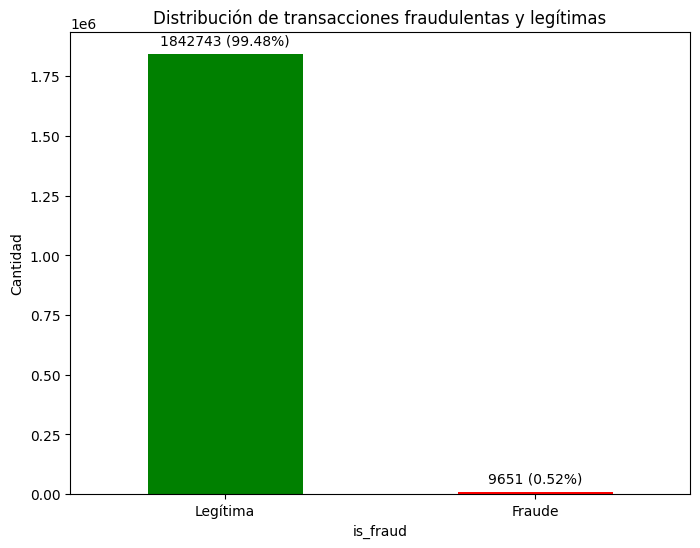

In [5]:
# Calcular la cantidad de transacciones fraudulentas y legítimas
fraud_counts = df['is_fraud'].value_counts()
total_transactions = fraud_counts.sum()

# Visualizar la distribución de la variable objetivo 'is_fraud'
plt.figure(figsize=(8, 6))
fraud_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de transacciones fraudulentas y legítimas')
plt.xlabel('is_fraud')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['Legítima', 'Fraude'], rotation=0)

# Mostrar la proporción en el gráfico
for i, count in enumerate(fraud_counts):
    plt.text(i, count + total_transactions * 0.02, f"{count} ({count / total_transactions:.2%})", ha='center')

plt.show()

In [6]:
# Calcular estadísticas descriptivas para características numéricas
numeric_features = df.select_dtypes(include=['float64', 'int64'])
numeric_summary = numeric_features.describe()
print("Estadísticas descriptivas para características numéricas:")
print(numeric_summary)

Estadísticas descriptivas para características numéricas:
             cc_num           amt           zip           lat          long  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   4.173860e+17  7.006357e+01  4.881326e+04  3.853931e+01 -9.022783e+01   
std    1.309115e+18  1.592540e+02  2.688185e+04  5.071470e+00  1.374789e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.640000e+00  2.623700e+04  3.466890e+01 -9.679800e+01   
50%    3.521417e+15  4.745000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.310000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.992100e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   8.864367e+04  1.358674e+09  3.853898e+01 -9.022794e+01  5.210015e

In [7]:
# # Calcular el número de subgráficos necesario
# num_features = len(numeric_features.columns)
# num_rows = (num_features // 3) + (1 if num_features % 3 > 0 else 0)

# # Visualizar distribuciones de características numéricas utilizando histogramas
# plt.figure(figsize=(15, num_rows * 5))
# for i, col in enumerate(numeric_features.columns):
#     plt.subplot(num_rows, 3, i+1)
#     sns.histplot(df[col], kde=True, color='skyblue')
#     plt.title(col)
# plt.tight_layout()
# plt.show()

# # Visualizar distribuciones de características numéricas utilizando boxplots
# plt.figure(figsize=(15, num_rows * 5))
# for i, col in enumerate(numeric_features.columns):
#     plt.subplot(num_rows, 3, i+1)
#     sns.boxplot(y=df[col], color='lightgreen')
#     plt.title(col)
# plt.tight_layout()
# plt.show()

#### Feature Engineering

Agregando caracteristicas de la fecha

In [8]:
# Convertir la columna 'trans_date_trans_time' a formato de fecha y hora
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Agregar características temporales
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek  # Lunes=0, Domingo=6
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

# Mostrar las primeras filas del conjunto de datos para verificar las nuevas características
df[['trans_date_trans_time', 'hour_of_day', 'day_of_week', 'month', 'year']].head()

,trans_date_trans_time,hour_of_day,day_of_week,month,year
0,2019-01-01 00:00:18,0,1,1,2019
1,2019-01-01 00:00:44,0,1,1,2019
2,2019-01-01 00:00:51,0,1,1,2019
3,2019-01-01 00:01:16,0,1,1,2019
4,2019-01-01 00:03:06,0,1,1,2019


Agregando caracteristicas de monto

In [9]:
# Calcular el monto promedio de transacción por cliente
avg_transaction_amt_by_customer = df.groupby('cc_num')['amt'].mean()
df['avg_transaction_amt'] = df['cc_num'].map(avg_transaction_amt_by_customer)

# Calcular la frecuencia de transacciones por cliente
transaction_count_by_customer = df['cc_num'].value_counts()
df['transaction_count'] = df['cc_num'].map(transaction_count_by_customer)

# Calcular la desviación estándar del monto de transacción por cliente
std_transaction_amt_by_customer = df.groupby('cc_num')['amt'].std()
df['std_transaction_amt'] = df['cc_num'].map(std_transaction_amt_by_customer)

# Mostrar las primeras filas del conjunto de datos para verificar las nuevas características
df[['amt', 'cc_num', 'avg_transaction_amt', 'std_transaction_amt', 'transaction_count']].head()

,amt,cc_num,avg_transaction_amt,std_transaction_amt,transaction_count
0,4.97,2703186189652095,89.408743,127.530101,2927
1,107.23,630423337322,56.078113,159.201852,4362
2,220.11,38859492057661,69.924272,116.688602,735
3,45.00,3534093764340240,80.090040,280.077880,743
4,41.96,375534208663984,95.341146,94.322842,2922


In [10]:
# Crear una nueva columna para almacenar la diversidad de comercios visitados por cada tarjetahabiente en todo el conjunto de datos
df['unique_merchants_visited'] = df.groupby('cc_num')['merchant'].transform('nunique')

# Mostrar las primeras filas del conjunto de datos para verificar las nuevas características
df[['cc_num', 'merchant', 'unique_merchants_visited']].head()

,cc_num,merchant,unique_merchants_visited
0,2703186189652095,"fraud_Rippin, Kub and Mann",660
1,630423337322,"fraud_Heller, Gutmann and Zieme",681
2,38859492057661,fraud_Lind-Buckridge,431
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",423
4,375534208663984,fraud_Keeling-Crist,652


Agregando caracteristicas de localizacion

In [11]:
# Función para calcular la distancia entre dos puntos geográficos
def calculate_distance(row):
    customer_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return geodesic(customer_location, merchant_location).kilometers

# Calcular la distancia desde el cliente hasta el comerciante
df['distance_to_merchant'] = df.apply(calculate_distance, axis=1)

df[['first', 'merchant', 'distance_to_merchant']].head()

,first,merchant,distance_to_merchant
0,Jennifer,"fraud_Rippin, Kub and Mann",78.773821
1,Stephanie,"fraud_Heller, Gutmann and Zieme",30.216618
2,Edward,fraud_Lind-Buckridge,108.102912
3,Jeremy,"fraud_Kutch, Hermiston and Farrell",95.685115
4,Tyler,fraud_Keeling-Crist,77.702395


In [12]:
# guardar el dataframe
df.to_csv('processed.csv', index=False)

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,first_time_at_merchant,hour_of_day,day_of_week,month,year,avg_transaction_amt,transaction_count,std_transaction_amt,unique_merchants_visited,distance_to_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,True,0,1,1,2019,89.408743,2927,127.530101,660,78.773821
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,True,0,1,1,2019,56.078113,4362,159.201852,681,30.216618
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,True,0,1,1,2019,69.924272,735,116.688602,431,108.102912
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,True,0,1,1,2019,80.090040,743,280.077880,423,95.685115
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,True,0,1,1,2019,95.341146,2922,94.322842,652,77.702395


### SMOTE y Division de Datos

In [21]:
df_processed = pd.read_csv('processed.csv')

# Seleccionar solo los datos del año 2019
df_subset_2019 = df_processed[df_processed['year'] == 2019]

In [25]:
X = df_subset_2019.drop(columns=['is_fraud'])
y = df_subset_2019['is_fraud']

# Seleccionar las caracteristicas numéricas
X_numeric = X.select_dtypes(include=['number'])

# Imputar valores faltantes en las características numéricas
imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

# Escalar las características numéricas para un mejor desempeño de SMOTE
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

In [26]:
# Dividir los datos en Train, Dev y Test
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_numeric_scaled, y, test_size=0.15, random_state=42)

# Dividir los datos de Train y Dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.176, random_state=42)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la forma de los datos después de aplicar SMOTE
print("Forma de X_train_resampled después de SMOTE:", X_train_resampled.shape)
print("Forma de y_train_resampled después de SMOTE:", y_train_resampled.shape)

Forma de X_train_resampled después de SMOTE: (1288174, 22)
Forma de y_train_resampled después de SMOTE: (1288174,)


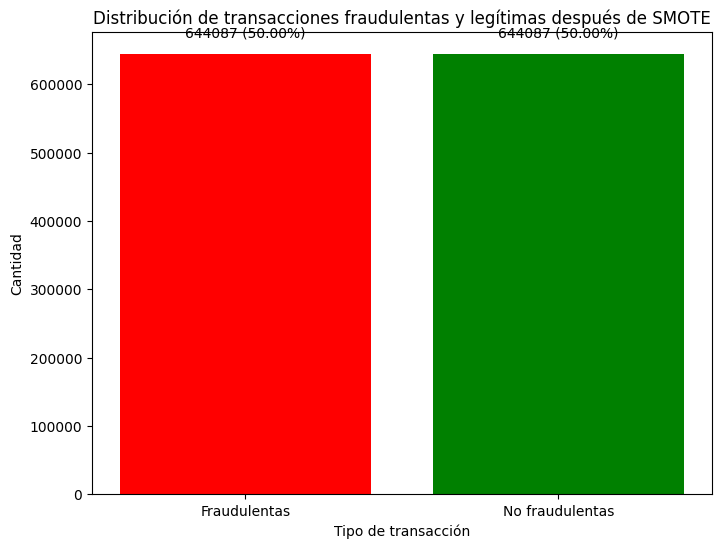

In [27]:
# Calcular la cantidad de transacciones fraudulentas y legítimas después de SMOTE
fraudulent_transactions_resampled = (y_train_resampled == 1).sum()
non_fraudulent_transactions_resampled = (y_train_resampled == 0).sum()
total_transactions_resampled = fraudulent_transactions_resampled + non_fraudulent_transactions_resampled

# Visualizar la distribución de transacciones fraudulentas y legítimas después de SMOTE
plt.figure(figsize=(8, 6))
plt.bar(['Fraudulentas', 'No fraudulentas'], [fraudulent_transactions_resampled, non_fraudulent_transactions_resampled], color=['red', 'green'])
plt.title('Distribución de transacciones fraudulentas y legítimas después de SMOTE')
plt.xlabel('Tipo de transacción')
plt.ylabel('Cantidad')

# Mostrar la proporción en el gráfico
for i, count in enumerate([fraudulent_transactions_resampled, non_fraudulent_transactions_resampled]):
    plt.text(i, count + total_transactions_resampled * 0.02, f"{count} ({count / total_transactions_resampled:.2%})", ha='center')

plt.show()

## Implementación de Modelos

### Random Forest

In [17]:
# # Entrenar el modelo de Random Forest con el conjunto de entrenamiento
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train_resampled, y_train_resampled)

# # Evaluar el rendimiento del modelo
# y_pred = rf_model.predict(X_test)

# print("Rendimiento del modelo:")
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))
# print("Precisión:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("F1-score:", f1_score(y_test, y_pred))

### XGBoost

Entrenamiento Inicial

In [42]:
# Convertir los datos al formato DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test)

# Definir los parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo XGBoost
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Guardar el modelo entrenado
xgb_model.save_model('XGB Models/xgb_model_2019.model')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:59:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [29]:
# Predecir sobre el conjunto de prueba
y_pred_proba = xgb_model.predict(dtest)

# Convertir las probabilidades pronosticadas en etiquetas de clase
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]

# Calcular y mostrar las métricas de evaluación
print("Rendimiento del modelo XGBoost:")
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Precisión:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Rendimiento del modelo XGBoost:
ROC-AUC: 0.9140115750748201
Precisión: 0.6492753623188405
Recall: 0.830655129789864
F1-score: 0.7288503253796096


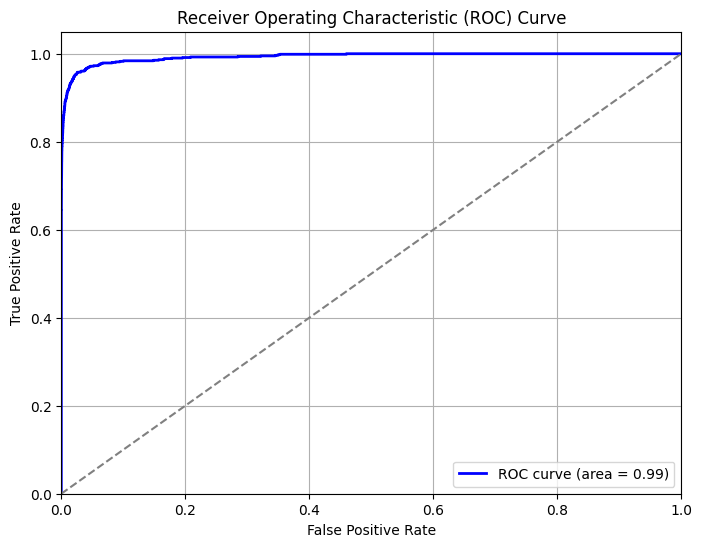

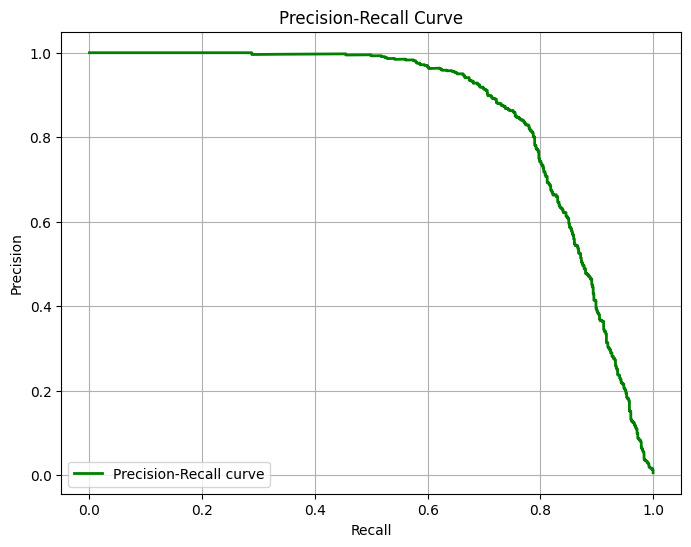

In [30]:
# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calcular la curva de precisión-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

Entrenamiento Incremental 1

In [43]:
# Cargar el modelo entrenado
xgb_model_incremental = xgb.Booster()
xgb_model_incremental.load_model('XGB Models/xgb_model_2019.model')

# Definir el nuevo batch de datos de enero 2020 a julio 2020
df_subset_2020_01_07 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 1) & (df_processed['month'] <= 7)]

In [39]:
# Seleccionar las características y la variable objetivo del nuevo batch
X_batch = df_subset_2020_01_07.drop(columns=['is_fraud'])
y_batch = df_subset_2020_01_07['is_fraud']

# Seleccionar las características numéricas
X_batch_numeric = X_batch.select_dtypes(include=['number'])

# Imputar valores faltantes en las características numéricas
imputer = SimpleImputer(strategy='mean')
X_batch_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_batch_numeric), columns=X_batch_numeric.columns)

# Escalar las características numéricas para un mejor desempeño de SMOTE
scaler = StandardScaler()
X_batch_numeric_scaled = scaler.fit_transform(X_batch_numeric_imputed)

In [40]:
# Dividir los datos en Train y Test
X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(X_batch_numeric_scaled, y_batch, test_size=0.2, random_state=42)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_batch_resampled, y_train_batch_resampled = smote.fit_resample(X_train_batch, y_train_batch)

In [45]:
# Convertir los datos del batch al formato DMatrix de XGBoost
dtrain_batch = xgb.DMatrix(X_train_batch_resampled, label=y_train_batch_resampled)
dtest_batch = xgb.DMatrix(X_test_batch)

# Entrenar el modelo XGBoost con el nuevo batch de datos
num_rounds_batch = 50 
xgb_model_incremental.update(dtrain_batch, num_rounds_batch)

# Guardar el modelo actualizado
xgb_model_incremental.save_model('XGB Models/xgb_model_2020_1.model')

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Entrenamiento Incremental 2

In [47]:
# Cargar el modelo entrenado
xgb_model_incremental2 = xgb.Booster()
xgb_model_incremental2.load_model('XGB Models/xgb_model_2020_1.model')

# Definir el nuevo batch de datos de agosto 2020 a diciembre 2020
df_subset_2020_08_12 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 8) & (df_processed['month'] <= 12)]

In [48]:
# Seleccionar las características y la variable objetivo del nuevo batch
X_batch2 = df_subset_2020_08_12.drop(columns=['is_fraud'])
y_batch2 = df_subset_2020_08_12['is_fraud']

# Seleccionar las características numéricas
X_batch2_numeric = X_batch2.select_dtypes(include=['number'])

# Imputar valores faltantes en las características numéricas
imputer = SimpleImputer(strategy='mean')
X_batch2_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_batch2_numeric), columns=X_batch2_numeric.columns)

# Escalar las características numéricas para un mejor desempeño de SMOTE
scaler = StandardScaler()
X_batch2_numeric_scaled = scaler.fit_transform(X_batch2_numeric_imputed)

In [ ]:
# Dividir los datos en Train y Test
X_train_batch2, X_test_batch2, y_train_batch2, y_test_batch2 = train_test_split(X_batch2_numeric_scaled, y_batch2, test_size=0.2, random_state=42)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_batch2_resampled, y_train_batch2_resampled = smote.fit_resample(X_train_batch2, y_train_batch2)

In [ ]:
# Convertir los datos del batch al formato DMatrix de XGBoost
dtrain_batch2 = xgb.DMatrix(X_train_batch2_resampled, label=y_train_batch2_resampled)
dtest_batch2 = xgb.DMatrix(X_test_batch2)

# Entrenar el modelo XGBoost con el nuevo batch de datos
num_rounds_batch2 = 25 
xgb_model_incremental2.update(dtrain_batch2, num_rounds_batch2)

# Guardar el modelo actualizado
xgb_model_incremental2.save_model('XGB Models/xgb_model_2020_2.model')